# Sentiment classification

## Model: Logistic regression

In [1]:
import tensorflow as tf
# load dataset from module keras.datasets.imdb
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.imdb.load_data()
x_train.shape

(25000,)

In [2]:
INDEX_FROM = 3  
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {k:(v+INDEX_FROM) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i , word) for (word, i) in word_index.items()
)

### Data cleaning

In [3]:
import numpy as np
import pandas as pd
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x.resize(x.shape[0],1)
y.resize(y.shape[0],1)

data = np.concatenate((x,y), axis=1)
df = pd.DataFrame(data=data,
                  index = [i for i in range(data.shape[0])],
                  columns=['review', 'sentiment'])



In [4]:
# remove newline(br) in each review
def remove_new_line_in_review(review):
    new_list = [x for x in review if x!=7 ]
    return new_list

df['review'] = df['review'].apply(lambda review: remove_new_line_in_review(review))

# convert list of word index to text
def word_index_to_text(review):
    text = " ".join(inverted_word_index[i] for i in review)
    return text
df['review'] = [word_index_to_text(review) for review in df['review']]


In [5]:
df.head()

,review,sentiment
0,<START> this film was just brilliant casting l...,1
1,<START> big hair big boobs bad music and a gia...,0
2,<START> this has to be one the worst films the...,0
3,<START> the scots excel at storytelling the tr...,1
4,<START> worst mistake my life br br i picked t...,0


In [6]:
import re
# import nltk
# nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def data_processing(text):
    text= text.lower()
    text = re.sub('<PAD>','',text)
    text = re.sub('<START>','',text)
    text = re.sub('<UNK>','',text)
    text = re.sub('<UNUSED>','',text)
    text = re.sub('br', '', text)
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)
    # return text

In [7]:
df.review = df['review'].apply(lambda x: data_processing(x))
# import nltk
# nltk.download('punkt')

In [8]:
df.head()

,review,sentiment
0,start film illiant casting location scenery st...,1
1,start big hair big boobs bad music giant safet...,0
2,start one worst films 1990s friends watching f...,0
3,start scots excel storytelling traditional sor...,1
4,start worst mistake life picked movie target 5...,0


### review distribution

In [9]:
df['no. words'] = df['review'].str.len()



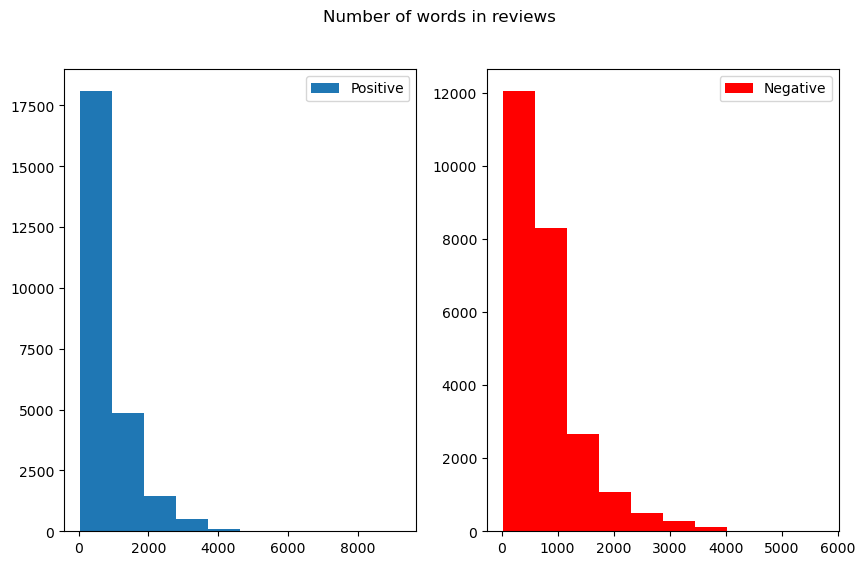

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].hist(df[df['sentiment']==1]['no. words'], label='Positive')
ax[0].legend(loc='upper right')
ax[1].hist(df[df['sentiment']==0]['no. words'], label='Negative', color='red')
ax[1].legend(loc='upper right')
fig.suptitle("Number of words in reviews")
plt.show()

In [11]:
pos_reviews = df[df['sentiment']==1]['review']
neg_reviews = df[df['sentiment']==1]['review']

In [12]:
from collections import Counter
count = Counter()
for text in pos_reviews.values:
    for word in text.split():
        count[word] +=1
count.most_common(15)


[('film', 41020),
 ('movie', 37489),
 ('one', 27025),
 ('start', 26473),
 ('like', 17709),
 ('good', 15024),
 ('great', 12963),
 ('story', 12870),
 ('well', 12825),
 ('time', 12743),
 ('see', 12260),
 ('also', 10792),
 ('really', 10740),
 ('would', 10473),
 ('even', 9616)]

In [13]:
pos_words = pd.DataFrame(data= count.most_common(15), columns=['word', 'count'])
pos_words.head()

,word,count
0,film,41020
1,movie,37489
2,one,27025
3,start,26473
4,like,17709


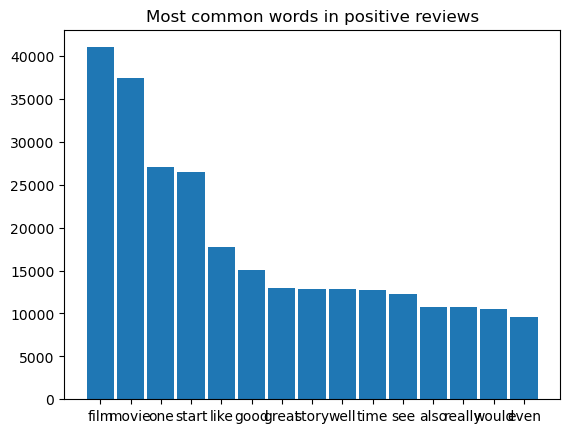

In [25]:
fig, ax = plt.subplots()
ax.bar(pos_words['word'],pos_words['count'], align='center', width=0.9, linewidth=1)
ax.set_title('Most common words in positive reviews')
plt.show()

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = df['review']
Y = df['sentiment']
vect = TfidfVectorizer()
X = vect.fit_transform(df['review'])
lab = preprocessing.LabelEncoder()
Y = lab.fit_transform(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [35]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

type(Y[0])

Size of x_train:  (35000, 79057)
Size of y_train:  (35000,)
Size of x_test:  (15000, 79057)
Size of y_test:  (15000,)


numpy.int32

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(x_train, y_train)
model_pred = model.predict(x_test)
model_acc = accuracy_score(model_pred, y_test)
print("Test accuracy: {:.2f}%".format(model_acc*100))


Test accuracy: 89.76%
